<a href="https://colab.research.google.com/github/Dong2Yo/DATA3960_1252/blob/main/Lectures/Segmentation_Strategy_RealEstate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation Strategies for Real Estate Market Data




## 1. RFM?

Can we adapt the RFM methodology to single-detached housing data?

Key Extensions Included:
- Investor vs Owner segmentation
- Renovation premium analysis
- Structural break modelling
- Macro-variable integration

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/Dong2Yo/Dataset/refs/heads/main/red_deer_single_family_2015_2024.csv',
                 parse_dates=['Listing_Date','Sold_Date'])
df.head()

,Listing_ID,Property_ID,Community,Price_Cluster,Listing_Price,Sold_Price,Listing_Date,Sold_Date,Bedrooms,Bathrooms,...,Ownership_Type,Property_Age,Renovation_Status,Year,Downturn_2015_2016,Boom_2021,Rate_Hike_2022_2023,Assessed_Value,Assessment_Gap,Assessment_Ratio
0,RD-100000,2126,Sunnybrook,Premium,707901.0,751176.3,2022-03-04,2022-04-06,4,2,...,Owner-Occupied,41,Renovated,2022,0,0,1,742110.853918,9065.446082,1.012216
1,RD-100001,2459,Inglewood,Entry,344398.0,363831.3,2021-02-11,2021-03-10,2,1,...,Owner-Occupied,36,Renovated,2021,0,1,0,351843.084828,11988.215172,1.034073
2,RD-100002,1860,Oriole Park,Entry,374473.0,363385.0,2021-04-17,2021-06-11,3,4,...,Owner-Occupied,32,Not Renovated,2021,0,1,0,348409.850694,14975.149306,1.042981
3,RD-100003,2294,Clearview Ridge,Mid-Low,330625.0,338673.3,2024-01-14,2024-02-28,4,2,...,Owner-Occupied,1,Renovated,2024,0,0,0,324312.194327,14361.105673,1.044282
4,RD-100004,2130,Timberlands,Mid,404309.0,436575.3,2016-02-01,2016-05-07,4,1,...,Investor,20,Renovated,2016,1,0,0,429592.225553,6983.074447,1.016255


### 1.1 Feature Engineering for RFM

🔷 Big Picture: What Are We Doing?

We are adapting RFM segmentation (originally from marketing) to real estate data from Red Deer.

We created:

>Recency → Most recent sale date

>Frequency → Number of times property sold

>Monetary → Average sold price

Now we are converting those into scores from 1 to 5 using pd.qcut().

**qcut() = quantile cut**

It:

- Sorts values

- Splits them into equal-sized groups

- Assigns labels (here 1–5)

🔷 Why We Use .rank(method='first')

***This is the key part.***

Real estate data has many ties, especially:

- Frequency (most properties sell once)

- Recency (many sold in same year)

If we feed tied values directly into qcut(), it may fail because:

>Quantile bin edges must be unique.

Ranking solves this.

In [4]:
snapshot_date = df['Sold_Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Property_ID').agg(
    Recency=('Sold_Date', lambda date: (snapshot_date - date.max()).days),
    Frequency=('Listing_ID', 'count'),
    Monetary=('Sold_Price', 'mean')
).reset_index()

# Stable scoring approach
rfm['R_Score'] = pd.qcut(
    rfm['Recency'].rank(method='first'),
    5,
    labels=[5,4,3,2,1]
)

rfm['F_Score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)

rfm['M_Score'] = pd.qcut(
    rfm['Monetary'],
    5,
    labels=[1,2,3,4,5]
)

rfm.head()

,Property_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,1000,102,5,378434.800,5,5,3
1,1001,723,5,302983.600,4,5,1
2,1002,1858,2,457829.450,2,2,5
3,1003,1127,2,317862.675,3,2,1
4,1004,297,2,405689.000,5,2,4


### Recency Score

Why reversed labels [5,4,3,2,1]?

Because:

- More recent sale = better (higher score)

- Larger date rank = more recent
  
So:

- Most Recent	→ Score 5
- Oldest	→ Score 1

We reverse the labels to reflect that logic.

### Frequency Score

- More sales = higher frequency

- Higher rank = more transactions

- So highest quintile gets score 5

Interpretation in housing:

- High F_Score → likely investor / flipper

- Low F_Score → typical owner-occupied

### Monetary Score

Here we did NOT rank first.

Because:

- Sold price is continuous

- Few exact duplicates

**Quantiles will naturally work**

Interpretation:

- High M_Score → high-value properties

- Low M_Score → entry-level housing

### 1.2 Investor vs Owner Analysis
Compare frequency and holding behaviour by ownership type.

In [6]:
df.groupby('Ownership_Type')['Sold_Price'].mean().round(2)

,Sold_Price
Ownership_Type,
Investor,364379.66
Owner-Occupied,393557.75


/tmp/ipython-input-1257754056.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ownership_Type', y='Sold_Price', data=ownership_summary_viz, palette='viridis')


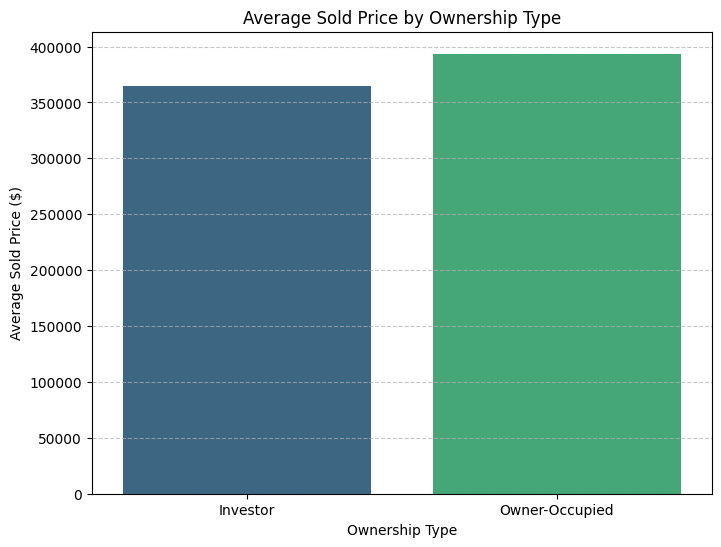

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recalculate or retrieve the summary if not already available in a variable
ownership_summary_viz = df.groupby('Ownership_Type')['Sold_Price'].mean().round(2).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Ownership_Type', y='Sold_Price', data=ownership_summary_viz, palette='viridis')
plt.title('Average Sold Price by Ownership Type')
plt.xlabel('Ownership Type')
plt.ylabel('Average Sold Price ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart above clearly shows the difference in average sold prices between 'Investor' and 'Owner-Occupied' properties.

### 1.3 Structural Break Regression Example
Illustration of how to test boom or downturn effects.

In [8]:
import statsmodels.api as sm

X = df[['Interest_Rate','Unemployment_Rate','Boom_2021','Downturn_2015_2016']]
X = sm.add_constant(X)
y = df['Sold_Price']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sold_Price   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     50.95
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           4.00e-42
Time:                        02:27:19   Log-Likelihood:                -66883.
No. Observations:                5090   AIC:                         1.338e+05
Df Residuals:                    5085   BIC:                         1.338e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.523e+05   2.62e+04     17.279      0.000    4.01e+05    5.04e+05
Interest_Rate      -1288.8754   2732.978     -0.472      0.637   -6646.689    4068.938
Unemployment_Rate  -8448.4382   2622.309     -3.222      0.001   -1.36e+04   -3307.583
Boom_2021           5.367e+04   6533.606      8.214      0.000    4.09e+04    6.65e+04
Downturn_2015_2016 -4.155e+04   5084.224     -8.173      0.000   -5.15e+04   -3.16e+04
==============================================================================
Omnibus:                      179.611   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.312
Skew:                           0.349   Prob(JB):                     2.29e-33
Kurtosis:                       2.530   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpret the **OLS (Ordinary Least Square) regression output**

---

#### 1️⃣ Overall Model Fit

#####  R-squared = **0.039**

* The model explains **3.9% of the variation** in `Sold_Price`.
* This is **very low**, meaning most price variation is driven by other factors not included (e.g., square footage, location, property type, etc.).
* For housing prices, this is expected if you only include macro variables.

##### Adjusted R-squared = **0.038**

* Very close to R² → adding variables didn’t artificially inflate explanatory power.
* Still weak explanatory strength.

---

#### 2️⃣ Is the Model Statistically Significant?

#####  F-statistic = 50.95

##### Prob (F-statistic) = 4.00e-42

This p-value is **extremely small (< 0.001)**.

The model as a whole is statistically significant.
Meaning: At least one predictor is related to `Sold_Price`.

However:

>Statistical significance ≠ practical strength
>Even though it’s statistically significant, the explanatory power is very small (R² = 3.9%).

---

#### 3️⃣ Interpreting Coefficients

Think of coefficients as:
**“Holding other variables constant…”**

---

#####  Intercept (const) = 452,300

When all predictors = 0:

* Predicted home price ≈ **$452,300**
* Often not practically meaningful (since rates are rarely 0), but necessary for the model.

---

##### Interest Rate

Coefficient = **–1,288.88**
p-value = **0.637**

❌ Not statistically significant.

Interpretation:

* A 1% increase in interest rate is associated with a $1,289 decrease in price,
* BUT the effect is not statistically different from zero.

Conclusion:
The interest rate does not meaningfully explain price variation in this model.

---

#####  Unemployment Rate

Coefficient = **–8,448.44**
p-value = **0.001**

✅ Statistically significant.

Interpretation:

* A 1% increase in unemployment is associated with about an **$8,448 decrease** in home prices.
* This makes economic sense.

---

##### Boom_2021 (Dummy Variable)

Coefficient = **+53,670**
p-value = **0.000**

✅ Highly significant.

Interpretation:

* During 2021 boom period, homes sold for about **$53,670 more**, holding other factors constant.

This captures pandemic housing surge effects.

---

#####  Downturn_2015_2016 (Dummy Variable)

Coefficient = **–41,550**
p-value = **0.000**

✅ Highly significant.

Interpretation:

* During 2015–2016 downturn, homes sold for about **$41,550 less**.

Likely reflecting oil shock effects (if your market is Edmonton).

---

#### 5️⃣ Big Picture Interpretation

##### What This Model Is Really Saying:

* Macroeconomic variables alone explain very little of home price variation (R² = 3.9%).
* Period effects (Boom / Downturn) matter a lot.
* Unemployment matters.
* Interest rate does not show significant effect here.
* Most housing price variation likely comes from:

  * Property characteristics
  * Location
  * Structural features
  * Neighborhood effects




### Why Classic RFM Is Weak for Real Estate

RFM assumes:

- High transaction frequency

- Repeated behavior by the same entity

- Loyalty patterns

Real estate:

- Low-frequency asset

- Long holding periods

- Macro-driven pricing

- Heterogeneous product

So the “customer-behaviour” logic doesn’t fully transfer.

### What We Should Learn

This code teaches three deeper ideas:

1️⃣ Framework Transfer Is Not Automatic

RFM was built for retail (high frequency).
Housing violates that assumption.

2️⃣ Data Distribution Matters

Always inspect value distribution before segmentation.

3️⃣ Technical Fix ≠ Conceptual Fix

Ranking fixes the error —
But it doesn’t solve whether quintiles make economic sense.



## 2. Lifecycle / Holding-Period Segmentation

Segment properties by holding duration + transaction count

Example:

- Long-Term Owner	10+ year holding
- Standard Turnover	4–10 years
- Short-Term Flip	< 3 years
- High-Frequency Trader	3+ sales

Why this works:

- Reflects ownership behavior

- Captures investor activity

- Aligns with real estate economics

- Works even with low transaction frequency

This is often better than Frequency quintiles.

In [9]:
# Sort for holding period calculation
df = df.sort_values(["Property_ID", "Sold_Date"])

df["Previous_Sale_Date"] = df.groupby("Property_ID")["Sold_Date"].shift(1)
df["Holding_Period_Days"] = (
    df["Sold_Date"] - df["Previous_Sale_Date"]
).dt.days

# Convert to years
df["Holding_Years"] = df["Holding_Period_Days"] / 365

# Define lifecycle segment
def lifecycle_segment(x):
    if pd.isna(x):
        return "First Sale"
    elif x < 3:
        return "Short-Term Flip"
    elif x < 10:
        return "Standard Turnover"
    else:
        return "Long-Term Owner"

df["Lifecycle_Segment"] = df["Holding_Years"].apply(lifecycle_segment)

df["Lifecycle_Segment"].value_counts()

,count
Lifecycle_Segment,
Short-Term Flip,2433
First Sale,1797
Standard Turnover,860


### Immediate Observation

Out of 5,090 transactions:

- Short-Term Flip ≈ 48%

- First Sale ≈ 35%

- Standard Turnover ≈ 17%

- Long-Term Owner = 0

That is an extremely high proportion of short holding periods.

### What This Means Structurally

In a real housing market like Red Deer:

- Most homes are owner-occupied

- Typical holding periods are 7–10 years

- Short-term flips are a minority activity

The results instead suggest:

The synthetic market behaves like a highly speculative environment.

That’s a modelling artifact — not necessarily an economic truth.

### Why This Happened

The holding period is computed only between repeat transactions.

In the dataset:

- Property_IDs were randomly generated

- Many properties reappear quickly

- Time between sales may be artificially short

This creates:

- Unrealistically high flip intensity

- Few long holding periods

- Distorted lifecycle segmentation

### Deeper Economic Interpretation

High Short-Term Flip proportion implies:

- High liquidity

- High investor presence

- Possibly strong price momentum periods

- Potential boom amplification



In [10]:
df.groupby(["Lifecycle_Segment","Ownership_Type"]).size()

Lifecycle_Segment  Ownership_Type
First Sale         Investor           408
                   Owner-Occupied    1389
Short-Term Flip    Investor           562
                   Owner-Occupied    1871
Standard Turnover  Investor           183
                   Owner-Occupied     677
dtype: int64

## 3. Market-Tier Segmentation (Structural)

We already added price clustering:

- Premium

- Mid-High

- Mid

- Entry

Segmentation by:

- Price per sqft

- Assessment gap

- Cluster appreciation

This is powerful because housing markets are stratified markets, not homogeneous.

In [13]:
df["Price_per_sqft"] = df["Sold_Price"] / df["Size_sqft"]

cluster_summary = df.groupby("Price_Cluster").agg({
    "Sold_Price":"mean",
    "Price_per_sqft":"mean",
    "Property_ID":"count"
}).rename(columns={"Property_ID":"Transactions"})

display(cluster_summary.round(2))

,Sold_Price,Price_per_sqft,Transactions
Price_Cluster,,,
Entry,319234.73,180.11,975
Mid,381295.19,215.72,1026
Mid-High,420040.29,237.22,970
Mid-Low,351321.87,200.59,1083
Premium,462532.06,266.15,1036


## 4. Appreciation-Based Segmentation (Investment-Oriented)

Segment properties by:

- Total appreciation %

- Annualized return

- Renovation-adjusted appreciation

Example:


- High Appreciation	>75th percentile
- Stable	Median band
- Underperforming	Bottom 25%

This reveals investment quality and neighbourhood momentum.

In [15]:
df = df.sort_values(["Property_ID","Sold_Date"])

df["Previous_Sold_Price"] = df.groupby("Property_ID")["Sold_Price"].shift(1)

df["Appreciation_Rate"] = (
    (df["Sold_Price"] - df["Previous_Sold_Price"]) /
    df["Previous_Sold_Price"]
)

# Remove first sales (no prior price)
app_df = df.dropna(subset=["Appreciation_Rate"]).copy()

# Segment into tertiles
app_df["Appreciation_Segment"] = pd.qcut(
    app_df["Appreciation_Rate"],
    3,
    labels=["Underperforming","Stable","High Appreciation"]
)

app_df["Appreciation_Segment"].value_counts()

,count
Appreciation_Segment,
Underperforming,1098
High Appreciation,1098
Stable,1097


## 5. Macro-Sensitivity Segmentation

Segment by:

- Interest rate sensitivity

- Structural break response

- Boom elasticity

Example:

- Rate-sensitive properties

- Boom-amplified neighborhoods

- Resilient segments

This connects micro housing data to macro forces.

In [16]:
import statsmodels.api as sm

X = df[["Interest_Rate","Unemployment_Rate",
        "Boom_2021","Downturn_2015_2016"]]

X = sm.add_constant(X)
y = df["Sold_Price"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Sold_Price   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     50.95
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           4.00e-42
Time:                        02:29:22   Log-Likelihood:                -66883.
No. Observations:                5090   AIC:                         1.338e+05
Df Residuals:                    5085   BIC:                         1.338e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.523e+05   2.62

## 6. Buyer-Type Segmentation (Behavioral)

Using the Ownership_Type variable:

- Investor

- Owner-Occupied

Then combine with:

- Renovation status

- Holding period

- Sale-to-list ratio

This reveals flipping strategy patterns.

In [18]:
ownership_summary = df.groupby("Ownership_Type").agg({
    "Sold_Price":"mean",
    "Holding_Years":"mean",
    "Property_ID":"count"
}).rename(columns={"Property_ID":"Transactions"})

ownership_summary.round(2)

,Sold_Price,Holding_Years,Transactions
Ownership_Type,,,
Investor,364379.66,2.08,1153
Owner-Occupied,393557.75,2.13,3937


## 7. K-Means / Unsupervised Clustering (Modern Analytics)

Use features like:

- Price_per_sqft

- Holding_Period

- Frequency

- Renovation

- Cluster

- Assessment_Gap

- Interest_Rate

Let the data define clusters.

Often you’ll discover:

- Premium long-hold homes

- Entry-level flip candidates

- Boom-driven investor properties

This is analytically stronger than fixed quintiles.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = df[[
    "Price_per_sqft",
    "Holding_Years",
    "Interest_Rate",
    "Assessment_Ratio"
]].fillna(0)

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster_Label"] = kmeans.fit_predict(scaled)

df["Cluster_Label"].value_counts()

,count
Cluster_Label,
3,1731
0,1678
2,1082
1,599


## Which Segmentation Is Strongest?

| Strategy          | Strength                    |
| ----------------- | --------------------------- |
| RFM               | Teaching framework transfer |
| Lifecycle         | Strong behavioral logic     |
| Price Tier        | Structural reality          |
| Appreciation      | Investment insight          |
| Macro-Sensitivity | Economic depth              |
| K-Means           | Modern data science         |
